Data ist from https://data.stadt-zuerich.ch/dataset/vbz-fahrzeiten-ogd . I used `head -n 1000000 fahrzeitensollist2017070220170708.csv > small.csv` to make a subset since I will do a lot of matrix multiplications which is slow.

In [3]:
%matplotlib inline
import numpy

from datetime import datetime, timedelta
from collections import defaultdict

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# Make plots reproducible
numpy.random.seed(0)

# Not necessary, but I like the ggplot style better
plt.style.use('ggplot') 

# Read csv to dataframe
df = pd.read_csv('small.csv')
df_hpunkt = pd.read_csv('haltepunkt.csv')
df_hstelle = pd.read_csv('haltestelle.csv')

In [4]:
halt_id = df_hstelle[df_hstelle['halt_lang'] == 'Zürich, Goldbrunnenplatz']['halt_id'].item()
linie = 9
selection = df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie)]
print("Found %d records." % (len(selection)))
display(selection.head(3))

Found 1364 records.


,linie,richtung,betriebsdatum,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,halt_kurz_von1,datum_von,...,fahrweg_id,fw_no,fw_typ,fw_kurz,fw_lang,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
25910,9,2,02.07.17,3045,9,4,1012,1,GOLP,02.07.17,...,50260,2,1,2,HEUR - HIRZ,137963,701,2060,1558,13552
25924,9,1,02.07.17,2087,6,30,1012,0,GOLP,02.07.17,...,50259,1,1,1,HIRZ - HEUR,135413,701,2627,11584,11393
25978,9,1,02.07.17,3054,7,30,1012,0,GOLP,02.07.17,...,50259,1,1,1,HIRZ - HEUR,136401,701,2627,11584,11393


## Multiple linear regression

Let's just see, if there is a dependence of the delays on the time of day.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Coefficients: 
 [-0.00336107  0.        ]
Mean squared error: 2695.34
Variance score: -0.02


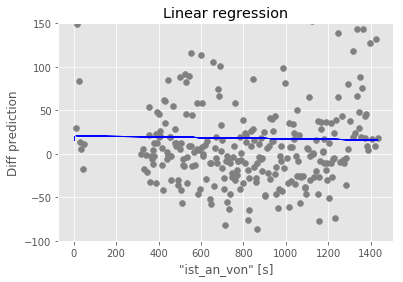

In [5]:
from sklearn import linear_model
from sklearn.svm import LinearSVC

def makeDatetime(date, seconds):
    """Returns datetime object rounded to the hour.
    
    date: date in format dd.mm.yy
    seconds: seconds of the day (int, can be negative)
    """
    hour = int(seconds / 3600) # same as numpy.floor()
    minute = int((seconds - hour * 3600) / 60)

    dt_obj = datetime.strptime(date, '%d.%m.%y')
    if hour >= 24:
        dt_obj += timedelta(days=1)
        hour -= 24
    if hour < 0:
        dt_obj += timedelta(days=-1)
        hour += 24
    dt_obj = dt_obj.replace(hour=hour)
    
    if minute >= 60:
        dt_obj += timedelta(hours=1)
        minute -= 60
    if minute < 0:
        dt_obj += timedelta(hours=-1)
        minute += 60
    dt_obj = dt_obj.replace(minute=minute)

    return dt_obj


data_x = []
data_y = []
for index, row in selection.iterrows():
    dt_obj = makeDatetime(row['datum_von'], row['ist_an_von'])

    # It may cause a mproble that "richtung" has discrete values
    #d = [dt_obj.hour * 60 + dt_obj.minute, row['richtung']]
    d = [dt_obj.hour * 60 + dt_obj.minute, 0]
    data_x.append(d)
    
    diff = row['ist_an_von'] - row['soll_an_von']
    data_y.append(diff)

# Convert to numpy array
data_x = numpy.array(data_x)#.reshape(len(data_x), 1)
data_y = numpy.array(data_y)
    
# Split data into training and test set
length = len(data_x)
data_x_train = data_x[:-int(length*1/5)]
data_x_test = data_x[-(length-len(data_x_train)):]

data_y_train = data_y[:-int(length*1/5)]
data_y_test = data_y[-(length-len(data_y_train)):]

# Create the model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_x_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % numpy.mean((regr.predict(data_x_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_x_test, data_y_test))

# Plot outputs
plt.scatter(data_x_test[:, 0], data_y_test, c='grey')
plt.plot(data_x_test, regr.predict(data_x_test), color='b', linewidth=1)
plt.gca().set_ylim([-100, 150])

plt.title('Linear regression')
plt.xlabel('"ist_an_von" [s]')
plt.ylabel('Diff prediction')
plt.show()

The model is not able to predict anything from the given data.

Let's plot the difference of times (delay) against time of day to explore the data.

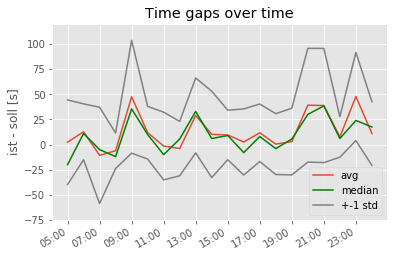

In [6]:
tod_diff = defaultdict(list)
# Take only the first rows because we only want about one day for a clear view
# The plot is reproducable for every successive selection
for index, row in selection[:200].iterrows():
    dt_obj = makeDatetime(row['datum_von'], row['ist_an_von']) # time from "soll"
    # Rounding to the hour to calculate mean, median etc. of the hour
    dt_obj = dt_obj.replace(minute=0)
    diff = row['ist_an_von'] - row['soll_an_von']
    
    tod_diff[dt_obj].append(diff)

# x
tod_times = []
# y
tod_avgs = [] 
tod_medians = []
tod_stdp = []
tod_stdn = []
for dt_obj in sorted(tod_diff):
    dt_diffs = tod_diff[dt_obj]

    mean = numpy.mean(dt_diffs)
    std = numpy.std(dt_diffs)
    
    tod_times.append(dt_obj)
    tod_avgs.append(mean)
    tod_medians.append(numpy.median(dt_diffs))
    tod_stdp.append(mean + std)
    tod_stdn.append(mean - std)

# Plot
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

ax.plot(tod_times, tod_avgs, label='avg')
ax.plot(tod_times, tod_medians, 'g', label='median')
ax.plot(tod_times, tod_stdp, 'grey', label='+-1 std')
ax.plot(tod_times, tod_stdn, 'grey', label='')
ax.legend()
ax.set_ylabel('ist - soll [s]')
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylim([-75, 120])

plt.title('Time gaps over time')
plt.show()

There seems to be some connection between time of day and delay. Why doesn't the linear regression reproduce that? The relationship between time and time difference is not linear. To forecast time series data with linear regression - like in this case - one would need a feature as input and then run through possible scenarios to forecast the effect on time difference/delay.